In [2]:
import ROOT as rt
import uproot
#from root_numpy import root2array, tree2array
#from root_pandas import read_root
import h5py 

from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import numpy as np
import numpy.lib.recfunctions as nlr
import pandas as pd
import os, sys
from matplotlib import pyplot as plt
import math
try:
    import setGPU
except:
    os.environ['KERAS_BACKEND'] = 'tensorflow'
    os.environ['CUDA_VISIBLE_DEVICES'] = '5'

Welcome to JupyROOT 6.22/02
setGPU: Setting GPU to: 3


In [3]:
def convert(tree, training_vars):
    array = tree.arrays()    
    df = pd.DataFrame(array, columns=training_vars)

    #feature = tree2array(tree,
    #                    branches = ['dRmm','dEtamm','dPhimm','M_jj','dEta_jj','Zep','dRmin_mj', 'dRmax_mj'
    #                               ,'dRmin_mmj','dRmax_mmj','dPhijj','leadingJet_pt','subleadingJet_pt',
    #                               'leadingJet_eta','subleadingJet_eta','cthetaCS','Higgs_mass','Higgs_pt','Higgs_eta' ],
    #                    selection = 'dRmm>-9000.')

    return df

In [4]:
training_vars = [b'leading_photon_pt', b'leading_photon_eta', b'leading_photon_phi', 
                 b'subleading_photon_pt', b'subleading_photon_eta', b'subleading_photon_phi',
                 b'leading_bjet_pt', b'leading_bjet_eta', b'leading_bjet_phi',
                 b'subleading_bjet_pt', b'subleading_bjet_eta', b'subleading_bjet_phi']

aug_vars = [b'dibjet_mass', b'diphoton_mass', b'event']

w_var = [b'genweight']

SIGNAL_FILE='/bigdata/shared/idutta/VBFHToMuMu.root'
BKG_FILE='/bigdata/shared/idutta/DYJetsToLL.root'

path = '/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/HHbbggAna/condor/output/'
paths = ["job_1_ntuple0625v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8.root", 
         "job_2_ntuple0625v1/VHToGG_M125_13TeV_amcatnloFXFX_madspin_pythia8.root", 
         "job_3_ntuple0625v1/ttHToGG_M125_TuneCP5_PSweights_13TeV-powheg-pythia8.root", 
         "job_4_ntuple0625v1/VBFHToGG_M125_13TeV_amcatnlo_pythia8.root", 
         "job_5_ntuple0625v1/GluGluHToGG_M125_TuneCP5_13TeV-amcatnloFXFX-pythia8.root", 
         "job_6_ntuple0625v1/GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8.root", 
         "job_7_ntuple0625v1/GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8.root", 
         "job_8_ntuple0625v1/DiPhotonJetsBox2BJets_MGG-80toInf_13TeV-Sherpa.root", 
         "job_9_ntuple0625v1/DiPhotonJetsBox1BJet_MGG-80toInf_13TeV-Sherpa.root", 
         "job_10_ntuple0625v1/DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root"]
names = ['GluGluToHH signal', 'VHToGG', 'ttHToGG', 'VBFHToGG', 'GluGluHToGG',
         'GJet_SmallPt', 'GJet_BigPt', 'DiPhotonJetsBox2B', 'DiPhotonJetsBox1B', 'DiPhotonJetsBox' ]
i = 8 # select sample

SIGNAL_FILE = uproot.open(path + 'job_1_ntuple0625v1/GluGluToHHTo2B2G_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8.root')
BKG_FILE = uproot.open(path + paths[i])
    
sigtree = SIGNAL_FILE['tree']
bkgtree = BKG_FILE['tree']

sig_frame_all = convert(sigtree, training_vars + aug_vars + w_var)
bkg_frame_all = convert(bkgtree, training_vars + aug_vars + w_var)

#print(sig_frame_all.iloc[:1])

#select events with cuts
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

sig_frame = sig_frame_all[sig_frame_all[b'diphoton_mass'] > 0][sig_frame_all[b'dibjet_mass'] > 0][training_vars]
bkg_frame = bkg_frame_all[bkg_frame_all[b'diphoton_mass'] > 0][bkg_frame_all[b'dibjet_mass'] > 0][training_vars]

sig_df = sig_frame_all[sig_frame_all[b'diphoton_mass'] > 0][sig_frame_all[b'dibjet_mass'] > 0][training_vars + w_var]
bkg_df = bkg_frame_all[bkg_frame_all[b'diphoton_mass'] > 0][bkg_frame_all[b'dibjet_mass'] > 0][training_vars + w_var]

#print(sig_frame[training_vars].head(), bkg_frame[training_vars].head())
#print(sig_frame.head(), bkg_frame.head())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [5]:
sig_df.head()

,b'leading_photon_pt',b'leading_photon_eta',b'leading_photon_phi',b'subleading_photon_pt',b'subleading_photon_eta',b'subleading_photon_phi',b'leading_bjet_pt',b'leading_bjet_eta',b'leading_bjet_phi',b'subleading_bjet_pt',b'subleading_bjet_eta',b'subleading_bjet_phi',b'genweight'
1,145.241119,0.918335,0.491089,75.707062,0.319824,1.547607,142.2500,2.209473,-2.042480,28.140625,0.004900,-0.789917,0.000139
5,81.548317,-0.114059,2.528809,68.587204,-0.079712,0.564209,80.1250,-1.288086,-0.381775,60.750000,-1.138916,-2.197266,-0.000139
7,109.037231,-0.835327,1.176514,87.997322,-0.765747,2.546875,115.9375,-1.357910,-1.699951,69.312500,-0.727295,-0.625854,0.000139
9,99.698898,-0.390930,-0.474426,54.716755,-0.526611,1.511963,92.5625,0.323792,2.379883,26.750000,2.041504,-3.094238,0.000139
10,78.673645,2.106934,-1.360596,74.914726,1.376465,0.152924,178.5000,1.395996,2.549316,31.062500,1.725098,0.694458,0.000139


In [6]:
#bkg_frame.head()
# Standardize
x_mean = bkg_frame.mean()
x_std = bkg_frame.std()

sig_frame = (sig_frame-x_mean)/x_std
bkg_frame = (bkg_frame-x_mean)/x_std
signal = sig_frame.values
background = bkg_frame.values
#print signal, background

# Shuffle before splitting into train-val
randix = np.arange(len(background))
np.random.shuffle(randix)
#np.random.shuffle(background)
#np.random.shuffle(signal)

randix2 = np.arange(len(signal))
np.random.shuffle(randix2)
signal_ = signal[randix2]
#signal_ = signal_[:len(background)]

background_ = background[randix]
background_ = background_[:len(signal)] # downsampling

sig_label = np.ones(len(signal_))
bkg_label = np.zeros(len(background_))

data = np.concatenate((signal_,background_))
label = np.concatenate((sig_label,bkg_label))

skf = StratifiedKFold(n_splits=5, shuffle=True)
skf.get_n_splits(data, label)
print(skf)

StratifiedKFold(n_splits=5, random_state=None, shuffle=True)


In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
#from skopt import gp_minimize

In [7]:
for train_index, test_index in skf.split(data, label):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = data[train_index], data[test_index]
    y_train, y_test = label[train_index], label[test_index]

TRAIN: [    1     2     3 ... 81225 81227 81228] TEST: [    0    19    21 ... 81200 81208 81226]
TRAIN: [    0     1     2 ... 81225 81226 81227] TEST: [    5     9    15 ... 81212 81218 81228]
TRAIN: [    0     1     2 ... 81226 81227 81228] TEST: [    8    11    14 ... 81219 81222 81225]
TRAIN: [    0     2     5 ... 81226 81227 81228] TEST: [    1     3     4 ... 81217 81221 81224]
TRAIN: [    0     1     3 ... 81225 81226 81228] TEST: [    2     7    10 ... 81220 81223 81227]


In [8]:
print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
model = Sequential()
model.add(Dense(100, input_dim=len(training_vars),activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(70, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(60, activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

(64984, 12)
(64984,)
(16245, 12)
(16245,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               1300      
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                7070      
_________________________________________________________________
dropout_1 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4260      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense

2021-07-21 20:08:41.982461: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-07-21 20:08:42.079569: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA GeForce GTX 1080 computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 20 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 298.32GiB/s
2021-07-21 20:08:42.079613: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-07-21 20:08:42.331548: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-07-21 20:08:42.474963: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2021-07-21 20:08:42.857484: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuran

In [9]:
print(x_train)
print(y_train)

[[ 1.4578643  -0.456763   -0.97149825 ... -0.881243    1.3104743
  -0.36738142]
 [ 1.5500187   0.637887    1.0422002  ... -0.75362355  0.1774174
  -1.694542  ]
 [ 1.1549736   0.50922793 -0.6081423  ...  0.20016393 -0.26518333
   1.1913699 ]
 ...
 [ 0.84802014  0.42179167 -0.83500373 ... -0.75362355  0.29827967
  -0.27046946]
 [-0.32168818  0.90289074  1.5466363  ...  0.1521867   0.5132208
   1.2663636 ]
 [ 0.19537131  1.1831659  -1.6367067  ...  2.8638601   1.3872184
   0.6846222 ]]
[1. 1. 1. ... 0. 0. 0.]


In [10]:
#print X_train, y_train
#print X_val, y_val
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [11]:
#https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
hist = model.fit(x_train, y_train, batch_size=150, epochs=50,verbose=1,validation_split=0.2,
                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min'),
                            ModelCheckpoint(filepath='model.h5', verbose=0)])
                 #lass_weight={0:10,1:1})

Epoch 1/50
347/347 [==============================] - 1s 3ms/step - loss: 0.4691 - accuracy: 0.7820 - val_loss: 0.9349 - val_accuracy: 0.5552
Epoch 2/50
347/347 [==============================] - 1s 2ms/step - loss: 0.4186 - accuracy: 0.8110 - val_loss: 0.8853 - val_accuracy: 0.5733
Epoch 3/50
347/347 [==============================] - 1s 2ms/step - loss: 0.4105 - accuracy: 0.8143 - val_loss: 0.8686 - val_accuracy: 0.5721
Epoch 4/50
347/347 [==============================] - 1s 2ms/step - loss: 0.4036 - accuracy: 0.8188 - val_loss: 0.8362 - val_accuracy: 0.5675
Epoch 5/50
347/347 [==============================] - 1s 2ms/step - loss: 0.4008 - accuracy: 0.8206 - val_loss: 0.9301 - val_accuracy: 0.5209
Epoch 6/50
347/347 [==============================] - 1s 2ms/step - loss: 0.3968 - accuracy: 0.8212 - val_loss: 0.8309 - val_accuracy: 0.5461
Epoch 7/50
347/347 [==============================] - 1s 2ms/step - loss: 0.3941 - accuracy: 0.8237 - val_loss: 0.8914 - val_accuracy: 0.4994
Epoch 

2021-07-21 20:08:48.825727: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [12]:
def show_losses( histories ):
    plt.figure(figsize=(10,10))
    #plt.ylim(bottom=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Error by Epoch')
    colors=[]
    do_acc=False
    for label,loss in histories:
        color = tuple(np.random.random(3))
        colors.append(color)
        l = label
        vl= label+" validation"
        if 'acc' in loss.history:
            l+=' (acc %2.4f)'% (loss.history['acc'][-1])
            do_acc = True
        if 'val_acc' in loss.history:
            vl+=' (val acc %2.4f)'% (loss.history['val_acc'][-1])
            do_acc = True
        plt.plot(loss.history['loss'], label=l, color=color)
        if 'val_loss' in loss.history:
            plt.plot(loss.history['val_loss'], lw=2, ls='dashed', label=vl, color=color)


    plt.legend()
    #plt.yscale('log')
    plt.show()
    if not do_acc: return
    plt.figure(figsize=(10,10))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    for i,(label,loss) in enumerate(histories):
        color = colors[i]
        if 'acc' in loss.history:
            plt.plot(loss.history['acc'], lw=2, label=label+" accuracy", color=color)
        if 'val_acc' in loss.history:
            plt.plot(loss.history['val_acc'], lw=2, ls='dashed', label=label+" validation accuracy", color=color)
    plt.legend(loc='lower right')
    plt.show()

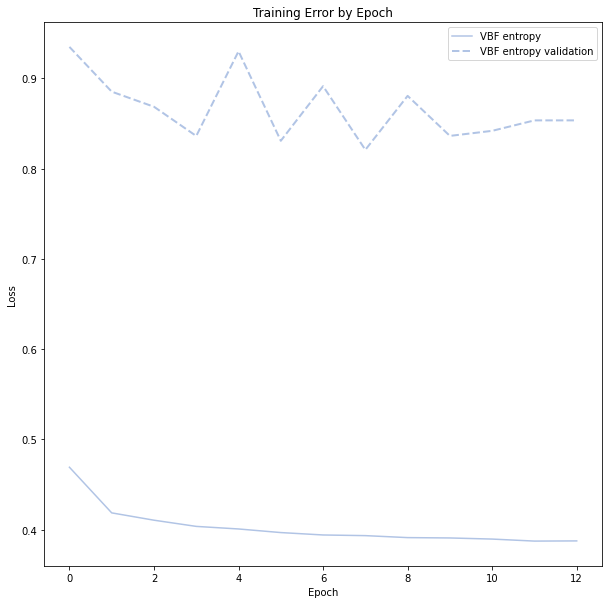

In [13]:
show_losses( [("VBF entropy", hist)])

In [21]:
def accuracy( p ):
    print(f'p: {p}')
    p_cat = np.argmax(p,axis=1)
    print(f'p_cat: {p_cat}')
    print(f'num_zeros = {(p_cat == 0).sum()}')
    print(f'num_ones = {(p_cat == 1).sum()}')
    print("Fraction of good prediction")
    print(len(np.where( p_cat == y_test)[0]))
    print(len(np.where( p_cat == y_test)[0])/float(len(p_cat)),"%")

In [22]:
accuracy( model.predict(x_test) )

p: [[0.88651526]
 [0.98008084]
 [0.6782486 ]
 ...
 [0.6053991 ]
 [0.2894394 ]
 [0.1368499 ]]
p_cat: [0 0 0 ... 0 0 0]
num_zeros = 16245
num_ones = 0
Fraction of good prediction
6607
0.406709756848261 %


In [16]:
from sklearn.metrics import roc_curve
y_pred = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

In [17]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [33]:
print(y_pred)
print(y_test)
bgd = y_pred[y_test == 0]
print(bgd)
print(f' # background: {len(bgd)}')
bgd_bin = []
for event in bgd:
    if event >= 0.5:
        bgd_bin.append(1)
    else:
        bgd_bin.append(0)
print(f' # false signal: {sum(bgd_bin)}')

sgl = y_pred[y_test == 1]
print(sgl)
print(f' # signal: {len(sgl)}')
sgl_bin = []
for event in sgl:
    if event >= 0.5:
        sgl_bin.append(1)
    else:
        sgl_bin.append(0)
print(f' # true signal: {sum(sgl_bin)}')

[0.88651526 0.98008084 0.6782486  ... 0.6053991  0.2894394  0.1368499 ]
[1. 1. 1. ... 0. 0. 0.]
[0.60637295 0.5883573  0.30900583 ... 0.6053991  0.2894394  0.1368499 ]
 # background: 6607
 # false signal: 3372
[0.88651526 0.98008084 0.6782486  ... 0.6185232  0.98490936 0.95479596]
 # signal: 9638
 # true signal: 9138


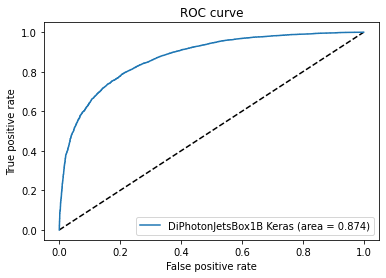

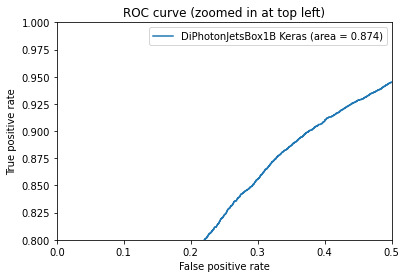

In [18]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label=names[i]+ ' Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/ROC_Plts/{names[i]}_ROC_curve.png', format='png')
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label= names[i] + ' Keras (area = {:.3f})'.format(auc_keras))
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/ROC_Plts/{names[i]}_ROC_curve_zoom')
plt.show()

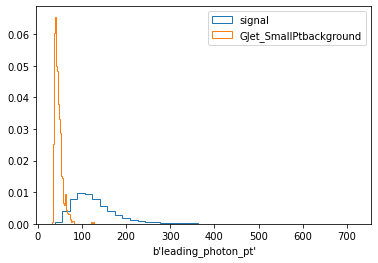

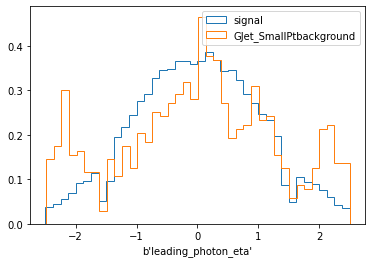

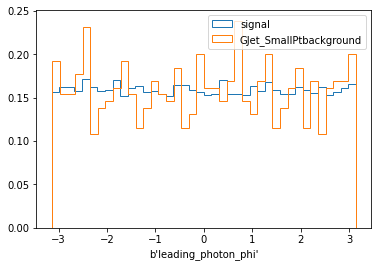

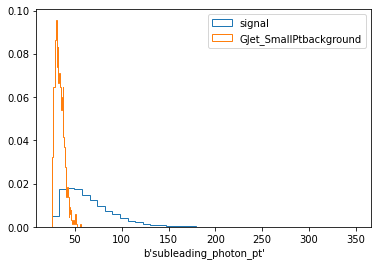

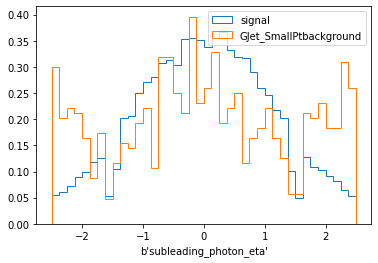

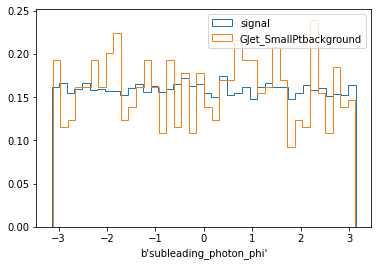

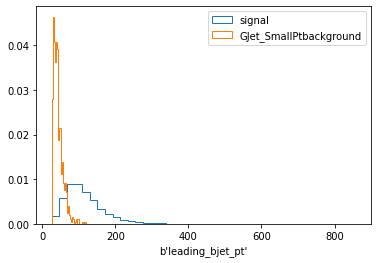

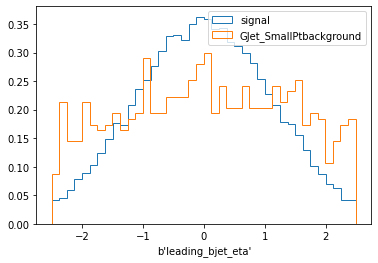

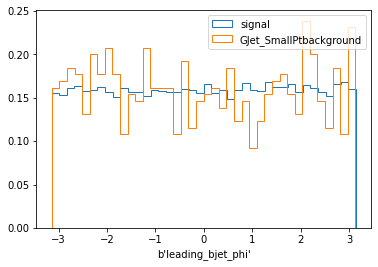

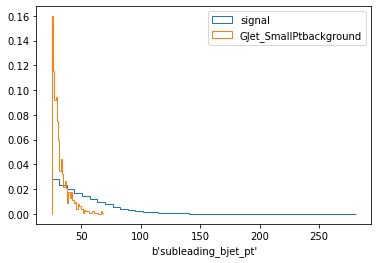

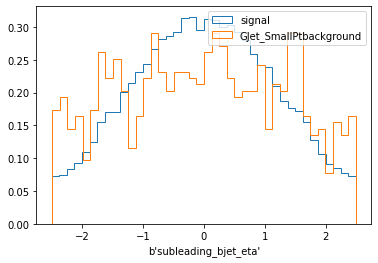

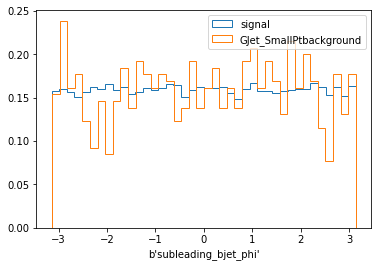

In [290]:
for hlf in training_vars:
    plt.figure()
    plt.hist(sig_df[hlf], bins=40, density=True, weights=sig_df[b'genweight'],
             histtype='step', label='signal')
    plt.hist(bkg_df[hlf], bins=40, density=True, weights=bkg_df[b'genweight'], 
             histtype='step', label= names[i] + 'background')
    plt.xlabel(hlf)
    plt.savefig(fname = f'/storage/af/user/schen7/CMSSW_9_4_2/src/Higgs/HHbbgg/notebook/ML/BackgroundVsSignal_Plts/{names[i]}_{hlf}')
    plt.legend(loc='best')

# 